In [14]:
import torch

In [15]:
print(torch.cuda.is_available()) # 查看CUDA是否可用
print(torch.cuda.device_count()) # 查看可用的CUDA数量
print(torch.version.cuda) # 查看CUDA的版本号
print(torch.cuda.device_count())

True
1
11.1
1


In [16]:
%cd F:\code\Informer2020-main\Informer2020-main_large_diff_dil\2.15_effinformer-2   

F:\code\Informer2020-main\Informer2020-main_large_diff_dil\2.15_effinformer-2


In [17]:
ls

 驱动器 F 中的卷是 phd
 卷的序列号是 F4E4-EFA1

 F:\code\Informer2020-main\Informer2020-main_large_diff_dil\2.15_effinformer-2 的目录

2023/02/22  08:53    <DIR>          .
2023/02/22  08:53    <DIR>          ..
2023/02/21  20:21    <DIR>          .idea
2023/02/22  09:00             9,416 A_array.mat
2023/02/21  21:17             9,416 A_array1.mat
2023/02/21  20:14    <DIR>          checkpoints
2023/02/19  22:43    <DIR>          data
2023/02/21  17:16    <DIR>          data - 副本
2023/02/19  22:36             2,200 Effinformer.sh
2023/02/21  20:13    <DIR>          EffInformer-main
2023/02/21  20:12         3,758,150 EffInformer-main.zip
2023/02/19  22:43    <DIR>          exp
2023/02/22  09:00         1,233,440 heatmap.eps
2023/02/22  09:00            29,019 heatmap.pdf
2023/02/22  09:00            76,897 heatmap.svg
2022/12/05  19:47             7,610 main_informer.py
2023/02/19  22:43    <DIR>          models
2023/02/21  20:16    <DIR>          results
2023/02/19  22:43    <DIR>          summary
2

In [18]:
import sys
if not 'EffInformer' in sys.path:
    sys.path += ['EffInformer']

In [19]:
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch

In [20]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'DAB' # data
args.root_path = './data/DAB' # root path of data file
args.data_path = 'DAB.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'OT' # target feature in S or MS task
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './checkpoints/' # location of model checkpoints

args.seq_len = 12 # input sequence length of Informer encoder
args.label_len = 6 # start token length of Informer decoder
args.pred_len = 1 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 2 # encoder input size
args.dec_in = 2 # decoder input size
args.c_out = 2 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 3 # num of encoder layers
args.d_layers = 2 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'ReGLU' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = False
args.padding = 0
args.freq = 'h'

args.batch_size = 32 
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 6
args.patience = 3
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [21]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

In [22]:
# Set augments by using data name
data_parser = {
    'DAB':{'data':'DAB.csv','T':'OT','M':[2,2,2],'S':[1,1,1],'MS':[2,2,1]},
    'ETTh1':{'data':'ETTh1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTh2':{'data':'ETTh2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm1':{'data':'ETTm1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm2':{'data':'ETTm2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]

In [23]:
args.detail_freq = args.freq
args.freq = args.freq[-1:]

In [24]:
print('Args in experiment:')
print(args)

Args in experiment:
{'model': 'informer', 'data': 'DAB', 'root_path': './data/DAB', 'data_path': 'DAB.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'checkpoints': './checkpoints/', 'seq_len': 12, 'label_len': 6, 'pred_len': 1, 'enc_in': 2, 'dec_in': 2, 'c_out': 2, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 3, 'd_layers': 2, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'ReGLU', 'distil': True, 'output_attention': False, 'mix': False, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 6, 'patience': 3, 'des': 'exp', 'use_gpu': True, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': 'h'}


In [25]:
Exp = Exp_Informer

Use GPU: cuda:0
>>>>>>>start training : informer_DAB_ftM_sl12_ll6_pl1_dm512_nh8_el3_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxFalse_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 14630
val 4146
test 2211
Epoch: 1 cost time: 20.2248752117157
Epoch: 1, Steps: 457 | Train Loss: 0.0480813 Vali Loss: 0.0032527 Test Loss: 0.0017034
Validation loss decreased (inf --> 0.003253).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2 cost time: 18.795799255371094
Epoch: 2, Steps: 457 | Train Loss: 0.0146728 Vali Loss: 0.0019425 Test Loss: 0.0008593
Validation loss decreased (0.003253 --> 0.001943).  Saving model ...
Updating learning rate to 5e-05
Epoch: 3 cost time: 18.404831886291504
Epoch: 3, Steps: 457 | Train Loss: 0.0090740 Vali Loss: 0.0017872 Test Loss: 0.0012242
Validation loss decreased (0.001943 --> 0.001787).  Saving model ...
Updating learning rate to 2.5e-05
Epoch: 4 cost time: 18.57537817955017
Epoch: 4, Steps: 457 | Train Loss: 0.0059953 Vali Loss: 0.0011631 Test Loss: 0.0006613
Valida

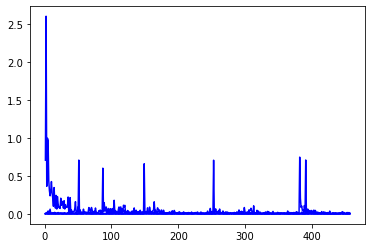

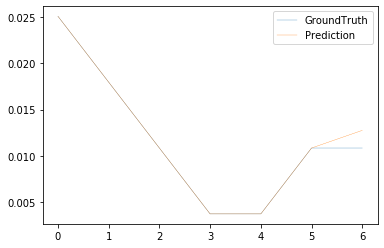

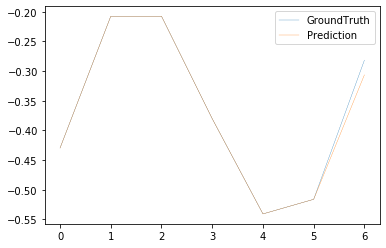

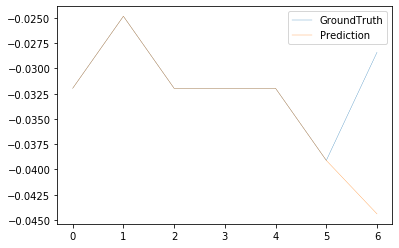

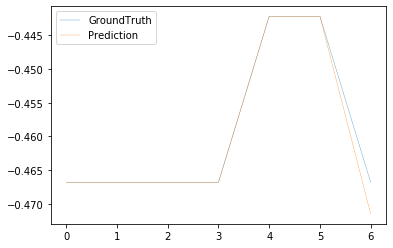

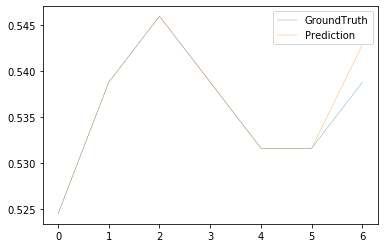

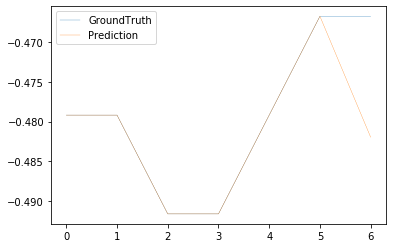

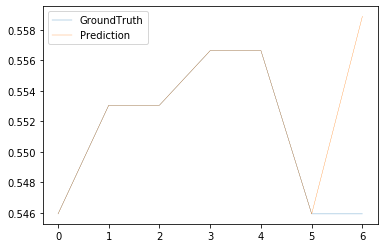

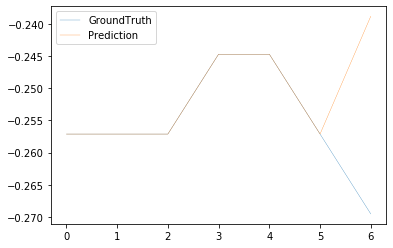

In [27]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)
    
    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)
    
    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

In [48]:
import os
# the prediction will be saved in ./results/{setting}/real_prediction.npy
import numpy as np



# set saved model path
setting = 'informer_DAB_ftM_sl12_ll6_pl1_dm512_nh8_el3_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxFalse_exp_0'
# path = os.path.join(args.checkpoints,setting,'checkpoint.pth')

In [49]:
from data.data_loader import Dataset_Custom
from torch.utils.data import DataLoader

Data = Dataset_Custom
timeenc = 0 if args.embed!='timeF' else 1
flag = 'test'; shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    freq=args.freq
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [50]:
import os

args.output_attention = True

exp = Exp(args)

model = exp.model

setting = 'informer_DAB_ftM_sl12_ll6_pl1_dm512_nh8_el3_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxFalse_exp_0'
path = os.path.join(args.checkpoints,setting,'checkpoint.pth')          
#os.path.join(args.checkpoints,setting,'checkpoint.pth')
model.load_state_dict(torch.load(path))

Use GPU: cuda:0


<All keys matched successfully>

In [51]:
preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')
preds = np.squeeze(preds)
trues = np.squeeze(trues)
preds.shape, trues.shape

((2208, 2), (2208, 2))

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

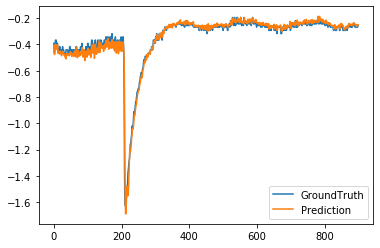

In [61]:
# draw HUFL prediction
plt.figure()
plt.plot(trues[1000:1900,0], label='GroundTruth')
plt.plot(preds[1000:1900,0], label='Prediction')
plt.legend()
plt.show()

In [41]:
from data.data_loader import Dataset_Custom
from torch.utils.data import DataLoader

Data = Dataset_Custom
timeenc = 0 if args.embed!='timeF' else 1
flag = 'test'; shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    freq=args.freq
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [42]:
import os

args.output_attention = True

exp = Exp(args)

model = exp.model

setting = 'informer_DAB_ftM_sl12_ll6_pl1_dm512_nh8_el3_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxFalse_exp_0'
path = os.path.join(args.checkpoints,setting,'checkpoint.pth')       
model.load_state_dict(torch.load(path))

Use GPU: cuda:0


<All keys matched successfully>

In [43]:
# attention visualization
idx = 0
for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(data_loader):
    if i!=idx:
        continue
    batch_x = batch_x.float().to(exp.device)
    batch_y = batch_y.float()

    batch_x_mark = batch_x_mark.float().to(exp.device)
    batch_y_mark = batch_y_mark.float().to(exp.device)
    
    dec_inp = torch.zeros_like(batch_y[:,-args.pred_len:,:]).float()
    dec_inp = torch.cat([batch_y[:,:args.label_len,:], dec_inp], dim=1).float().to(exp.device)
    
    outputs,attn = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

In [44]:
attn[0].shape, attn[1].shape #, attn[2].shape

(torch.Size([1, 8, 12, 12]), torch.Size([1, 8, 6, 6]))

(12, 12)


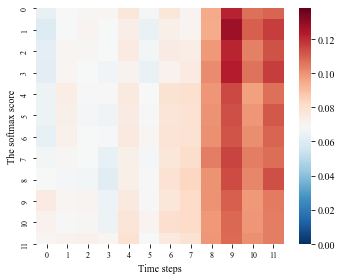

(12, 12)


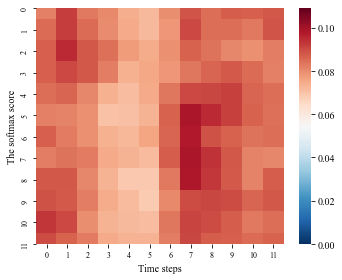

(12, 12)


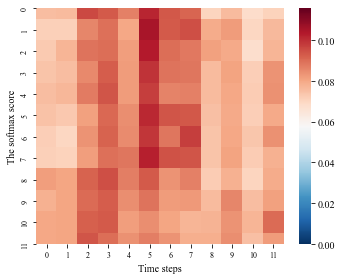

(12, 12)


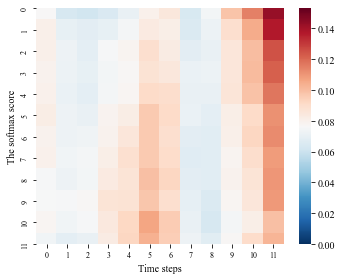

(12, 12)


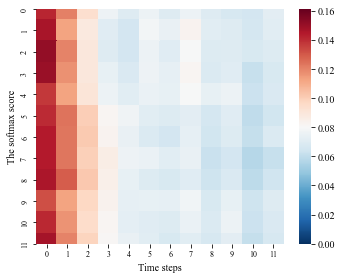

(12, 12)


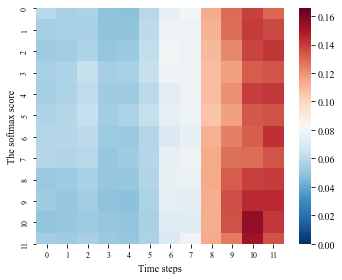

(12, 12)


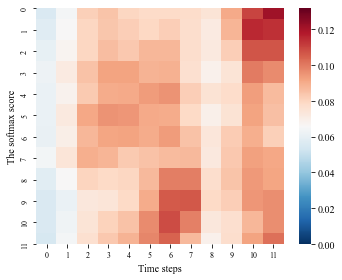

(12, 12)


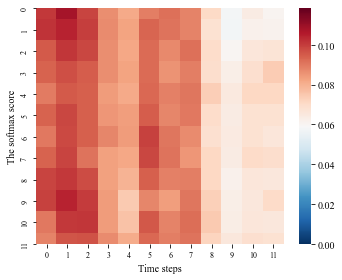

(8, 12, 12)


In [50]:
from scipy import io
# 假设循环生成的矩阵大小为 (3, 3)，需要生成 5 个矩阵
A_size = (12, 12)
num_matrices = 8

# 创建一个空的数组，用于保存生成的矩阵
A_array = np.empty((num_matrices,) + A_size)

layer = 0
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0,8):
    plt.figure(figsize=[5,4])
    A = attn[layer][0,h].detach().cpu().numpy()
    A_array[h] = A
    print(A.shape)
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01, cmap="RdBu_r")
    # 设置横轴和纵轴标题以及字体大小
    ax.set_xlabel("Time steps", fontsize=10)
    ax.set_ylabel("The softmax score", fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.rcParams['font.sans-serif'] = ['Times New Roman']
    plt.tight_layout() # 自动调整子图布局
    if h==0:
        plt.savefig("heatmap.pdf", format="pdf", dpi=1200)
        plt.savefig("heatmap.svg", format="svg", dpi=600)
        plt.savefig("heatmap.eps", format="eps", dpi=600)
    plt.show()

print(A_array.shape)

# 将矩阵保存为 mat 文件
io.savemat('A_array.mat', {' A_array':  A_array})

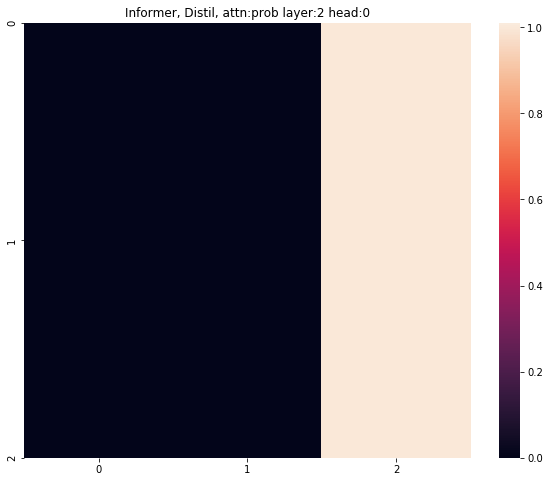

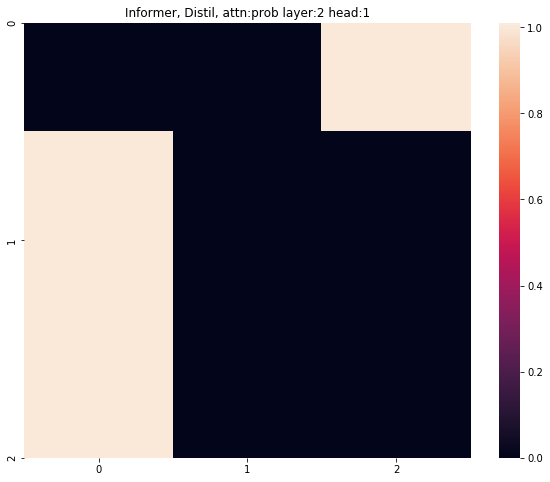

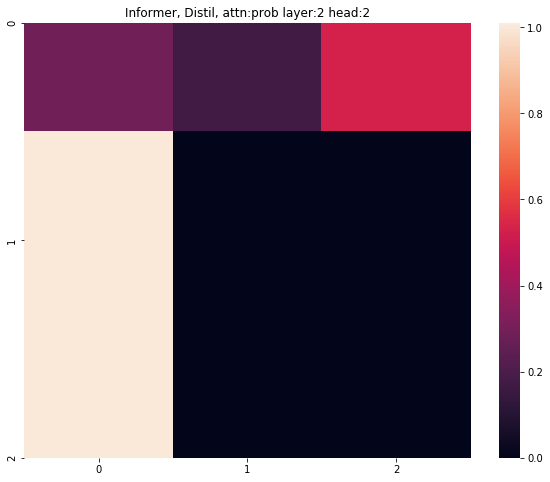

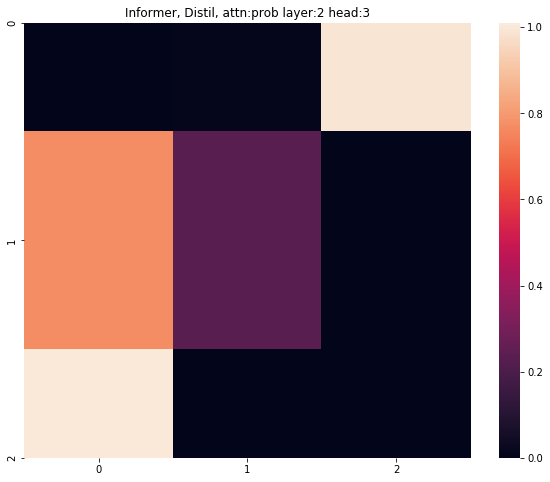

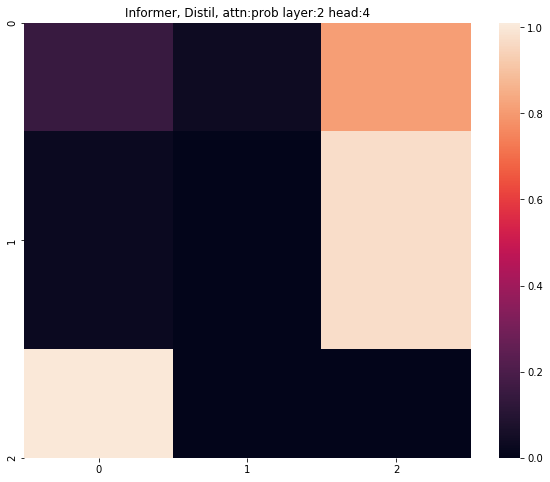

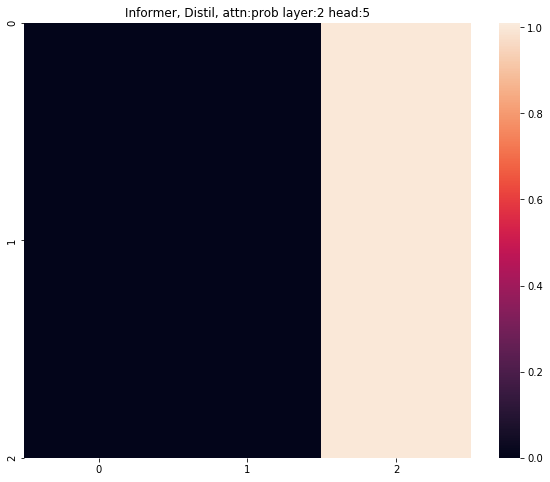

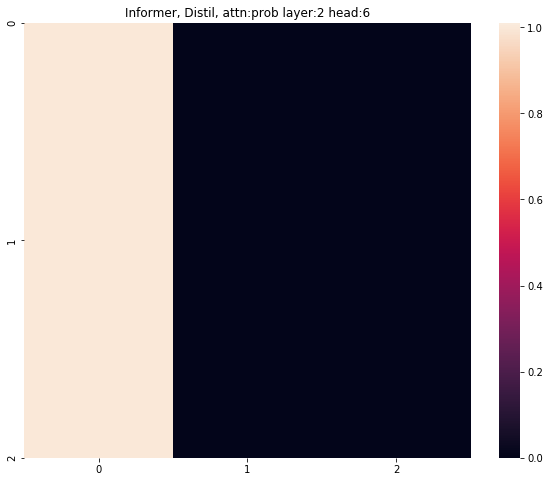

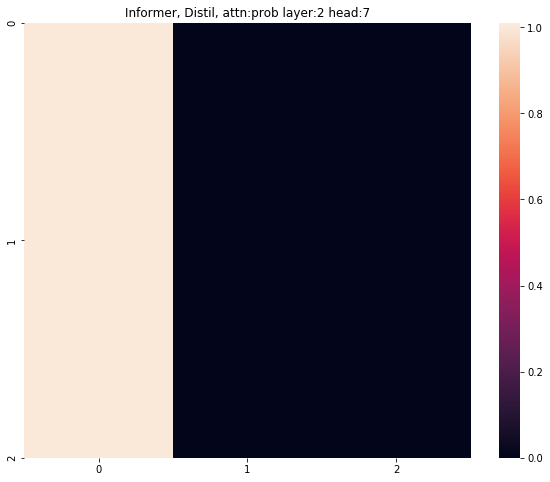

In [39]:
layer = 2
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0,8):
    plt.figure(figsize=[10,8])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()